# Close Gaps in Your Data with Smart Imputation <a href="https://colab.research.google.com/github/mostly-ai/mostlyai/blob/main/docs/tutorials/smart-imputation/smart-imputation.ipynb" target="_blank"><img src="https://img.shields.io/badge/Open%20in-Colab-blue?logo=google-colab" alt="Run on Colab"></a>

Dealing with datasets that contain missing values can be a challenge. This is especially so if the remaining non-missing values are not representative and thus provide a distorted, biased picture of the overall population.

In this tutorial we demonstrate how MOSTLY AI can help to close such gaps in your data via "Smart Imputation". By generating a synthetic dataset that doest not contain any missing values, it is possible to create a complete and sound representation of the underlying population. With this smartly imputed synthetic dataset it is then straightforward to accurately analyze the population as if all values were present in the first place.

For this tutorial, we will be using a modified version of the UCI Adult Income dataset, that itself stems from the 1994 American Community Survey by the US census bureau. This reduced dataset consists of 48,842 records and 10 mixed-type features. We will replace ~30% of the values for attribute `age` with missing values. We will do this randomly, but with a specified bias, so that we end up missing the age information particularly from the elder segments.

## Data Preparation for this Tutorial

We start by artificially injecting missing values into the original data via the following code.

In [ ]:
# Install SDK in CLIENT mode
%pip install -U mostlyai
# Or install in LOCAL mode
%pip install -U 'mostlyai[local]'  
# Note: Restart kernel session after installation!

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz")


def mask(prob, col=None, values=None):
    is_masked = np.random.uniform(size=df.shape[0]) < prob
    if col:
        is_masked = (is_masked) & (df[col].isin(values))
    df["age"] = df["age"].mask(is_masked)


np.random.seed(123)
mask(0.1, "age", [51 + i for i in range(20)])
mask(0.2, "age", [71 + i for i in range(20)])
mask(0.6, "income", [">50K"])
mask(0.6, "education", ["Doctorate", "Prof-school", "Masters"])
mask(0.6, "marital_status", ["Widowed", "Divorced"])
mask(0.6, "occupation", ["Exec-managerial"])
mask(0.6, "workclass", ["Self-emp-inc"])
tgt = df
print(f"Created original data with missing values with {tgt.shape[0]:,} records and {tgt.shape[1]} attributes")

Created original data with missing values with 48,842 records and 15 attributes


In [3]:
# let's show some samples
tgt[["workclass", "education", "marital_status", "age"]].sample(n=10, random_state=42)

,workclass,education,marital_status,age
7762,Private,HS-grad,Never-married,18.0
23881,Private,12th,Never-married,17.0
30507,Local-gov,HS-grad,Never-married,25.0
28911,Private,Some-college,Never-married,20.0
19484,Private,HS-grad,Never-married,47.0
43031,Private,Bachelors,Married-civ-spouse,33.0
28188,Private,HS-grad,Married-civ-spouse,38.0
12761,Private,11th,Married-civ-spouse,21.0
40834,Private,Assoc-acdm,Divorced,NaN
27875,Private,HS-grad,Married-civ-spouse,55.0


In [4]:
# report share of missing values for column `age`
print(f"{tgt['age'].isna().mean():.1%} of values for column `age` are missing")

32.7% of values for column `age` are missing


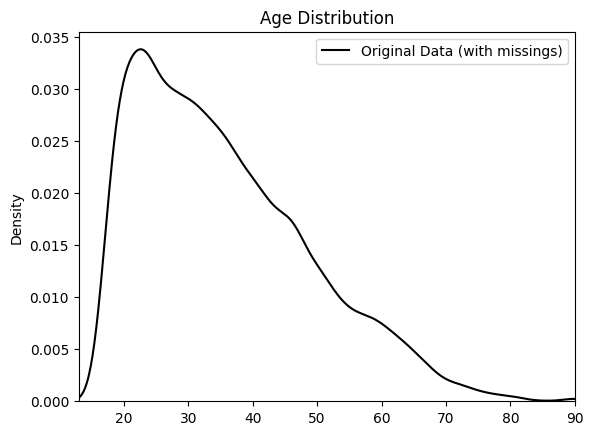

In [5]:
# plot distribution of column `age`
import matplotlib.pyplot as plt

tgt.age.plot(kind="kde", label="Original Data (with missings)", color="black")
_ = plt.legend(loc="upper right")
_ = plt.title("Age Distribution")
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

## Synthesize Data via MOSTLY AI

The code below will automatically create a Generator using the MOSTLY AI Synthetic Data SDK. The we will use that Generator to create a Synthetic dataset with turned on Smart Imputation for the `age` column.

In [ ]:
from mostlyai.sdk import MostlyAI

# initialize SDK
mostly = MostlyAI()

In [ ]:
# train a generator on the original training data
g = mostly.train(data=tgt, name="Smart Imputation Tutorial - Census")

In [ ]:
# generate synthetic data with imputed age column
config = {
    "name": "Smart Imputation Tutorial - Census",
    "tables": [{"name": "data", "configuration": {"imputation": {"columns": ["age"]}}}],
}
sd = mostly.generate(g, config=config)
syn = sd.data()
print(f"Created synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

If you want to, you can now check the distribution based on the Model QA and Data QA reports. Download these via `sd.reports()`, or display inline via `sd.reports(display=True)`. As one can see, the distributiosn are faithfully learned, and also include the right share of missing values. The Data QA visualizes then the distributions of the delivered Synthetic dataset. And there we can see, that the share of missing values (`N/A`) has dropped to 0%, and that the distribution has been shifted towards older age buckets.

In [ ]:
sd.reports(display=True)

## Analyze the results

We can now explore the imputed synthetic data.

In [ ]:
# show some synthetic samples
syn[["workclass", "education", "marital_status", "age"]].sample(n=10, random_state=42)

In [ ]:
# report share of missing values for column `age`
print(f"{syn['age'].isna().mean():.1%} of values for column `age` are missing")

In [ ]:
# plot side-by-side
import matplotlib.pyplot as plt

tgt.age.plot(kind="kde", label="Original Data (with missings)", color="black")
syn.age.plot(kind="kde", label="Synthetic Data (imputed)", color="green")
_ = plt.title("Age Distribution")
_ = plt.legend(loc="upper right")
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

As one can see, the imputed synthetic data does NOT contain any missing values anymore. But it's also apparent, that the synthetic age distribution is significantly distinct from the distribution of the non-missing values that were provided.

So, let's then check, whether that new distribution is more representative of the ground truth, i.e. the underlying original age distribution.

In [ ]:
raw = pd.read_csv("https://github.com/mostly-ai/public-demo-data/raw/dev/census/census.csv.gz")

# plot side-by-side
import matplotlib.pyplot as plt

tgt.age.plot(kind="kde", label="Original Data (with missings)", color="black")
raw.age.plot(kind="kde", label="Original Data (ground truth)", color="red")
syn.age.plot(kind="kde", label="Synthetic Data (imputed)", color="green")
_ = plt.title("Age Distribution")
_ = plt.legend(loc="upper right")
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

## Imputing Missing Values in the Original Data

If you only need to impute missing values in the original dataset, rather than generating privacy-preserving synthetic data, you can use conditional generation. In this case, the seed dataset consists of the rows where the age value is missing. To impute the missing age values, you can exclude the age column from the seed dataset and then use the imputation option to generate the missing values for that column.

The MOSTLY AI generator provides a full distribution estimate for the missing values. When you perform imputation, you receive a distribution sample. To obtain a point estimate (i.e., the best estimate for age for a specific record), you can calculate a statistics, such as the median or average, based on the generated values. For example, you can generate 100 imputed values to obtain a distribution estimate, and then calculate the median or average of these values to get the point estimate for the age.

In [19]:
# create a seed dataset that is used as the condition for the imputation of missing age
seed = tgt.loc[tgt["age"].isna(), :].drop(columns="age")

In [ ]:
# probe generator for imputed age column 100x times
import numpy as np

age_imputed = []
for i in range(100):
    if i % 10 == 0:
        print(i, "of", 100, "imputations done")
    config = {
        "tables": [
            {
                "name": "data",
                "configuration": {
                    "sample_seed_data": seed,
                    "imputation": {"columns": ["age"]},
                },
            }
        ],
    }
    syn = mostly.probe(g, config=config)
    age_imputed.append(syn.age.to_numpy())

In [21]:
# take a single imputed value (this is NOT a point estimate, but a distribution sample)
syn_one = tgt.copy()
syn_one.loc[seed.index, "age"] = age_imputed[0]

# take the median imputed value
syn_q50 = tgt.copy()
syn_q50.loc[seed.index, "age"] = np.median(np.vstack(age_imputed), axis=0)

# take the avg imputed value
syn_avg = tgt.copy()
syn_avg.loc[seed.index, "age"] = np.mean(np.vstack(age_imputed), axis=0)

In [ ]:
tgt.age.plot(kind="kde", label="Original Data (with missings)", color="black")
raw.age.plot(kind="kde", label="Original Data (ground truth)", color="red")
syn_one.age.plot(kind="kde", label="Synthetic Data (one)", color="blue")
syn_q50.age.plot(kind="kde", label="Synthetic Data (q50)", color="lightgreen")
syn_avg.age.plot(kind="kde", label="Synthetic Data (avg)", color="darkgreen")
_ = plt.title("Age Distribution")
_ = plt.legend(loc="upper right")
_ = plt.xlim(13, 90)
_ = plt.ylim(0, None)

Let’s examine the first missing value in the dataset, its actual value, the distribution estimate, and calculate the point estimate.

In [ ]:
idx = tgt[tgt["age"].isna()].index[0]
raw.iloc[idx]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

pd.Series(np.vstack(age_imputed)[:, idx], name="age").plot(kind="kde", label="Distribution estimate", color="green")

ax.axvline(x=raw.iloc[idx]["age"], color="black", linestyle="-", label="Actual value")
ax.axvline(x=syn_q50.iloc[idx]["age"], color="lightgreen", linestyle="--", label="Point estimate: median")
ax.axvline(x=syn_avg.iloc[idx]["age"], color="darkgreen", linestyle="--", label="Point estimate: average")
ax.axvline(x=syn_one.iloc[idx]["age"], color="blue", linestyle="-", label="Distribution sample: imputation 1")

# Add labels and title
ax.set_xlabel("age")
ax.set_ylabel("Density")
ax.set_title("Comparison of the Actual Value and Its Estimates")

# Show legend
ax.legend()

# Show the plot
plt.show()

## Conclusion

As we can see, the smartly imputed synthetic data is perfectly able to recover the original, suppressed distribution! As an analyst you can proceed with the exploratory and descriptive analysis, as if the values were present in the first place.

Additionally, you can use the tool as a distribution estimator for the missing values in your original dataset. Simply apply conditional generation with the original seed and impute the column(s) of interest.

## Further Reading

See also here for a benchmark of Smart Imputation with respect to other commonly used imputation techniques: https://mostly.ai/blog/smart-imputation-with-synthetic-data